In [1]:
import sys
sys.path.append("..")

import src.utils.linearization_utils
from src.datamodules import IEGenericDataset
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

In [2]:
import json
import numpy as np
import os 
import jsonlines
import inspect 
from tqdm import tqdm

DATA_DIR='../data'

def read_jsonl(path_to_file):
    with open(path_to_file, 'r') as f:
        data = [json.loads(line) for line in f]
    return data

def write_jsonl(path_to_file, data, mode='w'):
    with jsonlines.open(path_to_file, mode) as writer:
        writer.write_all(data)

def get_data(data_dir, split):
    data = read_jsonl(os.path.join(data_dir, split + '.jsonl'))
    return data

In [3]:
# reload linearization_utils to get the latest changes
import importlib
importlib.reload(src.utils.linearization_utils)

class_name_e  = "fully_expanded"
lc_e = src.utils.linearization_utils.get_linearization_class(class_name_e)

class_name_et  = "fully_expanded_et"
lc_et = src.utils.linearization_utils.get_linearization_class(class_name_et)

class_name = "subject_collapsed"
lc_sc = src.utils.linearization_utils.get_linearization_class(class_name)

In [4]:
def _get_num_tokens(text, tokenizer):
    return tokenizer(text, return_tensors="pt")["input_ids"].numel()

def _add_input_num_tokens_to_dp(dp, tokenizer):
    num_tokens_dict = dp.get('num_tokens_dict', {})
    num_tokens_dict['text'] = _get_num_tokens(dp['text'], tokenizer)
    dp['num_tokens_dict'] = num_tokens_dict

def _add_input_num_tokens_to_data(data, tokenizer):
    for dp in tqdm(data, desc="Adding input length information."):
        _add_input_num_tokens_to_dp(dp, tokenizer)

def add_input_info(data_dir, split, output_split, tokenizer, output_dir=None):
    if output_dir is None:
        output_dir = data_dir

    print(f"Adding input info to split `{split}` in `{data_dir}`...")
    data = get_data(data_dir, split)

    # process the data
    _add_input_num_tokens_to_data(data, tokenizer)
    
    if output_split != None:
        output_file_path = os.path.join(data_dir, output_split + '.jsonl')
        print(f"Saving the processed data to {output_file_path}...")
        write_jsonl(output_file_path, data)
    
    return data

def _add_target_num_tokens_to_dp(dp, tokenizer, linearization_class_id, add_target=False):
    triplet_list_text = IEGenericDataset.get_triplets_surface_form(dp)
    lc_et = src.utils.linearization_utils.get_linearization_class(linearization_class_id)
    text, tokenized_text = lc_et.triplet_list_to_text(triplet_list_text, tokenizer)
    num_tokens_dict = dp.get('num_tokens_dict', {})
    num_tokens_dict[f'target_{linearization_class_id}'] = len(tokenized_text)
    dp['num_tokens_dict'] = num_tokens_dict
    if add_target:
        target_dict = dp.get('target_dict', {})
        target_dict[f'target_{linearization_class_id}'] = text
        dp['target_dict'] = target_dict

def _add_target_num_tokens_to_data(data, tokenizer, linearization_class_id, add_target=False):
    for dp in tqdm(data, desc="Adding target length information."):
        _add_target_num_tokens_to_dp(dp, tokenizer, linearization_class_id, add_target)


def add_target_info(data_dir, split, output_split, tokenizer, linearization_class_id, add_target, output_dir=None):
    if output_dir is None:
        output_dir = data_dir

    print(f"Adding target info (linearization_class_id `{linearization_class_id}`) to split `{split}` in `{data_dir}`...")
    data = get_data(data_dir, split)

    # process the data
    _add_target_num_tokens_to_data(data, tokenizer, linearization_class_id, add_target)
    
    if output_split != None:
        output_file_path = os.path.join(data_dir, output_split + '.jsonl')
        print(f"Saving the processed data to `{output_file_path}`...")
        write_jsonl(output_file_path, data)
    
    return data

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_num_tokens(data, dataset_name, split, fields=None, binwidth=10, ax=None, fig_size=(10, 5)):
    if fields is None:
        fields = data[0]['num_tokens_dict'].keys()

    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    
    for field in fields:
        num_tokens = [dp['num_tokens_dict'][field] for dp in data]
        ax.hist(num_tokens, bins=np.arange(min(num_tokens), max(num_tokens) + binwidth, binwidth), histtype=u'step', label=field)

    plt.title(f"[{dataset_name} / {split}] Token distribution")
    plt.legend()
    plt.show()

def visualize_num_elements_per_linearization(data, dataset_name, split, fields=None, binwidth=10, ax=None, fig_size=(10, 5)):
    if fields is None:
        fields = data[0]['target_dict'].keys()

    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)

    for linearization_class_id in fields:
        lin_class = src.utils.linearization_utils.get_linearization_class(linearization_class_id.lstrip('target_'))

        x = []
        for dp in data:
            target = dp['target_dict'][linearization_class_id]
            if "flatten" in inspect.signature(lin_class).parameters.keys():
                target_parts = lin_class(target, flatten=True)
            else:
                target_parts = lin_class._split_text(target)
            x.append(len(target_parts))

        ax.hist(x, bins=np.arange(min(x), max(x) + binwidth, binwidth), histtype=u'step', label=linearization_class_id.lstrip('target_'))

    plt.title(f"[{dataset_name} / {split}] # of entity + relation subparts distribution")
    plt.legend()
    plt.show()

In [13]:
dp

{'id': 54977,
 'triplets': [{'subject': {'surfaceform': 'Alberta', 'uri': 'Q1951'},
   'object': {'surfaceform': 'Edmonton', 'uri': 'Q2096'},
   'predicate': {'surfaceform': 'capital', 'uri': 'P36'}}],
 'text': 'Terra Informa is a weekly, half-hour environmental news program produced out of CJSR Radio in Edmonton, Alberta. ',
 'entities': [{'surfaceform': 'Alberta', 'uri': 'Q1951'},
  {'surfaceform': 'Edmonton', 'uri': 'Q2096'}],
 'relations': [{'surfaceform': 'capital', 'uri': 'P36'}],
 'num_tokens_target': 17,
 'num_tokens_input': 27}

In [16]:
linearization_class_id = 'fully_expanded'

dataset_name='rebel'
split='val'
output_split=None
output_split='val_token_stats'

data_input = add_input_info(data_dir=os.path.join(DATA_DIR, dataset_name), split=split, output_split=output_split, tokenizer=tokenizer)

Adding input info to split `val` in `../data/rebel`...


Adding input length information.: 100%|██████████| 54978/54978 [00:06<00:00, 8200.38it/s]


Saving the processed data to ../data/rebel/val_token_stats.jsonl...


In [20]:
def are_triplets_with_same_subjects_consecutive(triplets):
    past_subjects = set()
    curr_subject = None

    for triplet in triplets:
        if curr_subject is None:
            curr_subject = triplet[0]
            
        if triplet[0] != curr_subject:
            if triplet[0] in past_subjects:
                # the new subject has already been seen before
                return False
            past_subjects.add(triplet[0])
            curr_subject = triplet[0]
    
    return True

dataset_name='rebel'
split='val_ordered'
data = get_data(data_dir=os.path.join(DATA_DIR, dataset_name), split=split)

print(len(data))
for idx, dp in enumerate(data):
    if idx in set([idx]):
        continue
    triplets = IEGenericDataset.get_triplets_surface_form(dp)
    assert are_triplets_with_same_subjects_consecutive(triplets)
    

54978


In [22]:
dataset_name='sdg'
split='val_code_davinci_ordered'
data_ordered = get_data(data_dir=os.path.join(DATA_DIR, dataset_name), split=split)

In [23]:
dataset_name='sdg'
split='val_code_davinci'
data = get_data(data_dir=os.path.join(DATA_DIR, dataset_name), split=split)

In [25]:
for idx, (unordered_dp, ordered_dp) in enumerate(zip(data, data_ordered)):
    unordered_triplets = IEGenericDataset.get_triplets_surface_form(unordered_dp)
    ordered_triplets = IEGenericDataset.get_triplets_surface_form(ordered_dp)
    if unordered_triplets != ordered_triplets:
        print(idx)
        break

0


In [31]:
IEGenericDataset.get_triplets_surface_form(data[idx])

[('Swedish_Open_Cultural_Heritage', 'file format', 'XML'),
 ('Swedish_Open_Cultural_Heritage', 'part of', 'Semantic_Web'),
 ('Swedish_Open_Cultural_Heritage',
  'programming language',
  'Java_(programming_language)'),
 ('Swedish_Open_Cultural_Heritage', 'instance of', 'Free_software')]

In [33]:
IEGenericDataset.get_triplets_surface_form(data_ordered[idx])

[('Swedish_Open_Cultural_Heritage', 'instance of', 'Free_software'),
 ('Swedish_Open_Cultural_Heritage', 'file format', 'XML'),
 ('Swedish_Open_Cultural_Heritage',
  'programming language',
  'Java_(programming_language)'),
 ('Swedish_Open_Cultural_Heritage', 'part of', 'Semantic_Web')]

In [11]:
# def get_start_index_parts(text, sf_parts):
#     max_subseq_len = len(sf_parts)
    
#     for l in range(max_subseq_len, 0, -1):
#         for i in range(max_subseq_len - l + 1):
#             subseq = ' '.join(sf_parts[i:i+l])
#             try:
#                 return text.index(subseq)
#             except ValueError:
#                 pass
    
#     return None

# def _get_start_index(dp, sf):
#     for entity in dp['entities']:
#         if entity['surfaceform'] == sf:
#             idx = entity['mention_start_index']
    
#     if idx is None:
#         return float('inf')

#     return idx
    
# input_text = dp['text'].lower()
# entities = dp['entities']
# entity_surfaceforms_parts = [entity['surfaceform'].lower().split("_") for entity in entities]
# mention_start_index = [get_start_index_parts(input_text, sf_parts) for sf_parts in entity_surfaceforms_parts]
# for idx, entity in zip(mention_start_index, entities):
#     entity['mention_start_index'] = idx

# # apply_ordering
# sub_obj_sf_pairs = [(triplet['subject']['surfaceform'], triplet['object']['surfaceform']) for triplet in dp['triplets']]
# sub_obj_start_idx_pairs = np.array([(_get_start_index(dp, sub_sf), _get_start_index(dp, obj_sf)) for sub_sf, obj_sf in sub_obj_sf_pairs]).T
# sub_ent_name = [triplet['subject']['surfaceform'] for triplet in dp['triplets']]

# ordered_indices = np.lexsort((sub_obj_start_idx_pairs[1,:], sub_obj_start_idx_pairs[0,:]))
# [IEGenericDataset.get_triplets_surface_form(dp)[idx] for idx in ordered_indices]

In [12]:
# dataset_name='rebel'
# split='val_token_stats'
# output_split=None
# output_split='val_token_stats'


# add_target = True
# linearization_class_id = 'fully_expanded'
# data_target = add_target_info(data_dir=os.path.join(DATA_DIR, dataset_name), split=split, output_split=output_split, tokenizer=tokenizer, linearization_class_id=linearization_class_id, add_target=True)

# linearization_class_id = 'fully_expanded_et'
# data_target_et = add_target_info(data_dir=os.path.join(DATA_DIR, dataset_name), split=split, output_split=output_split, tokenizer=tokenizer, linearization_class_id=linearization_class_id, add_target=True)

# linearization_class_id = 'subject_collapsed'
# data_target_et = add_target_info(data_dir=os.path.join(DATA_DIR, dataset_name), split=split, output_split=output_split, tokenizer=tokenizer, linearization_class_id=linearization_class_id, add_target=True)

In [6]:
def add_stats_to_split(dataset_name, split, output_split, add_input_stats, lin_class_ids_to_add):
    if add_input_stats:
        data_input = add_input_info(data_dir=os.path.join(DATA_DIR, dataset_name), split=split, output_split=output_split, tokenizer=tokenizer)
        split = output_split
    
    for linearization_class_id in lin_class_ids_to_add:
        add_target = True
        data_target = add_target_info(data_dir=os.path.join(DATA_DIR, dataset_name), split=split, output_split=output_split, tokenizer=tokenizer, linearization_class_id=linearization_class_id, add_target=True)
        split = output_split

Adding input info to split `val` in `../data/rebel`...


Adding input length information.: 100%|██████████| 54978/54978 [00:06<00:00, 8372.50it/s]


Saving the processed data to ../data/rebel/val_token_stats.jsonl...
Adding target info (linearization_class_id `fully_expanded`) to split `val_token_stats` in `../data/rebel`...


Adding target length information.: 100%|██████████| 54978/54978 [00:41<00:00, 1336.48it/s]


Saving the processed data to `../data/rebel/val_token_stats.jsonl`...
Adding target info (linearization_class_id `fully_expanded_et`) to split `val_token_stats` in `../data/rebel`...


Adding target length information.: 100%|██████████| 54978/54978 [00:41<00:00, 1329.79it/s]


Saving the processed data to `../data/rebel/val_token_stats.jsonl`...
Adding target info (linearization_class_id `subject_collapsed`) to split `val_token_stats` in `../data/rebel`...


Adding target length information.: 100%|██████████| 54978/54978 [00:39<00:00, 1402.31it/s]


Saving the processed data to `../data/rebel/val_token_stats.jsonl`...


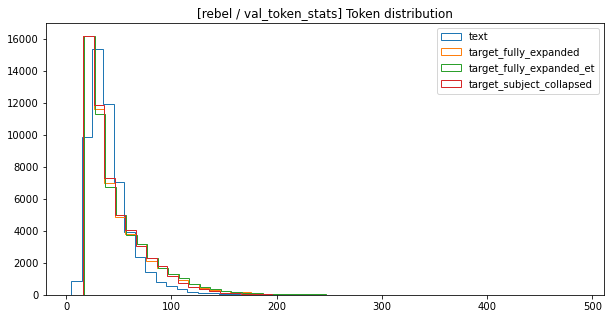

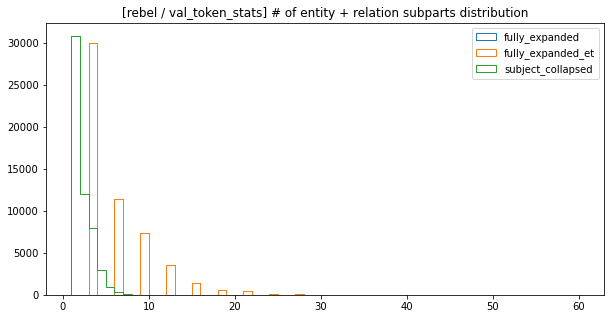

In [8]:
dataset_name='rebel'
split='val'
output_split='val_token_stats'
lin_class_ids_to_add = ['fully_expanded', 'fully_expanded_et', 'subject_collapsed']

add_stats_to_split(dataset_name, split, output_split, add_input_stats=True, lin_class_ids_to_add=lin_class_ids_to_add)

dataset_name='rebel'
split = "val_token_stats"
data = get_data(os.path.join(DATA_DIR, dataset_name), split)

visualize_num_tokens(data, dataset_name, split, ['text', 'target_fully_expanded', 'target_fully_expanded_et', 'target_subject_collapsed'])
visualize_num_elements_per_linearization(data, dataset_name, split, binwidth=1)

Adding input info to split `val_code_davinci_ordered` in `../data/sdg`...


Adding input length information.: 100%|██████████| 15000/15000 [00:02<00:00, 7364.76it/s]


Saving the processed data to ../data/sdg/val_code_davinci_ordered_token_stats.jsonl...
Adding target info (linearization_class_id `fully_expanded`) to split `val_code_davinci_ordered_token_stats` in `../data/sdg`...


Adding target length information.: 100%|██████████| 15000/15000 [00:29<00:00, 507.62it/s]


Saving the processed data to `../data/sdg/val_code_davinci_ordered_token_stats.jsonl`...
Adding target info (linearization_class_id `fully_expanded_et`) to split `val_code_davinci_ordered_token_stats` in `../data/sdg`...


Adding target length information.: 100%|██████████| 15000/15000 [00:29<00:00, 510.80it/s]


Saving the processed data to `../data/sdg/val_code_davinci_ordered_token_stats.jsonl`...
Adding target info (linearization_class_id `subject_collapsed`) to split `val_code_davinci_ordered_token_stats` in `../data/sdg`...


Adding target length information.: 100%|██████████| 15000/15000 [00:21<00:00, 701.25it/s]


Saving the processed data to `../data/sdg/val_code_davinci_ordered_token_stats.jsonl`...


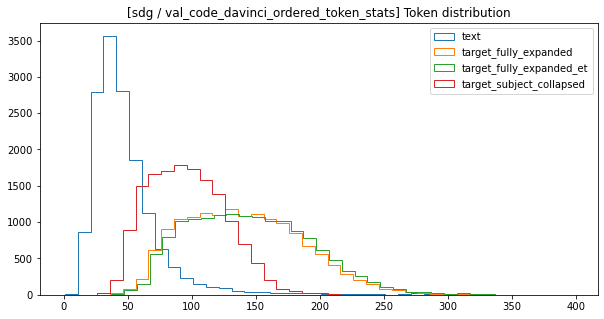

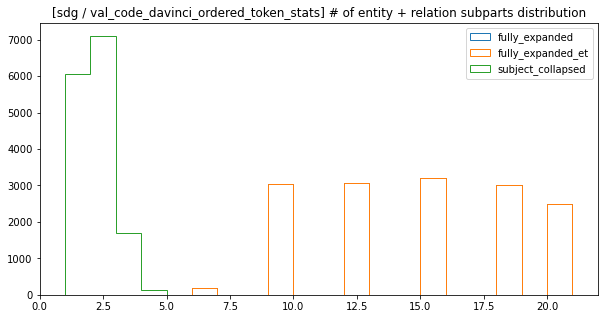

In [9]:
dataset_name='sdg'
split='val_code_davinci_ordered'
output_split='val_code_davinci_ordered_token_stats'
lin_class_ids_to_add = ['fully_expanded', 'fully_expanded_et', 'subject_collapsed']
add_stats_to_split(dataset_name, split, output_split, add_input_stats=True, lin_class_ids_to_add=lin_class_ids_to_add)

dataset_name='sdg'
split = "val_code_davinci_ordered_token_stats"
data = get_data(os.path.join(DATA_DIR, dataset_name), split)

visualize_num_tokens(data, dataset_name, split, ['text', 'target_fully_expanded', 'target_fully_expanded_et', 'target_subject_collapsed'])
visualize_num_elements_per_linearization(data, dataset_name, split, binwidth=1)

In [16]:
dataset_name='rebel'
split='val'

data = get_data(os.path.join(DATA_DIR, dataset_name), split)

In [18]:
data[0]

{'id': 0,
 'triplets': [{'subject': {'surfaceform': 'Trinity_Peninsula',
    'uri': 'Q2038835'},
   'object': {'surfaceform': 'Graham_Land', 'uri': 'Q618370'},
   'predicate': {'surfaceform': 'part of', 'uri': 'P361'}},
  {'subject': {'surfaceform': 'Trinity_Peninsula', 'uri': 'Q2038835'},
   'object': {'surfaceform': 'Antarctica', 'uri': 'Q51'},
   'predicate': {'surfaceform': 'continent', 'uri': 'P30'}},
  {'subject': {'surfaceform': 'Graham_Land', 'uri': 'Q618370'},
   'object': {'surfaceform': 'Antarctica', 'uri': 'Q51'},
   'predicate': {'surfaceform': 'continent', 'uri': 'P30'}}],
 'text': "Chelopech Hill (, ‘Halm Chelopech’ \\'h&lm che-lo-'pech\\) is the ice-covered hill rising to 946 m in the north foothills of Detroit Plateau on Trinity Peninsula in Graham Land, Antarctica. ",
 'entities': [{'surfaceform': 'Trinity_Peninsula', 'uri': 'Q2038835'},
  {'surfaceform': 'Graham_Land', 'uri': 'Q618370'},
  {'surfaceform': 'Antarctica', 'uri': 'Q51'}],
 'relations': [{'surfaceform': '

In [7]:
# Add target linearization to all datapoints
# Add num_tokens_to_all

In [11]:
for dp in data:
    break

In [15]:
triplets_list_text = IEGenericDataset.get_triplets_surface_form(dp)
lc_et.triplet_list_to_text(triplets_list_text)

('[s] Trinity Peninsula [r] part_of [o] Graham Land [et] [s] Trinity Peninsula [r] continent [o] Antarctica [et] [s] Graham Land [r] continent [o] Antarctica [et]',
 None)

In [16]:
dp['text']

"Chelopech Hill (, ‘Halm Chelopech’ \\'h&lm che-lo-'pech\\) is the ice-covered hill rising to 946 m in the north foothills of Detroit Plateau on Trinity Peninsula in Graham Land, Antarctica. "

In [14]:
dataset_name='sdg'
split='val_code_davinci_ordered'
output_split=None
# output_split='val_code_davinci_ordered'

data = get_data(os.path.join(DATA_DIR, dataset_name), split)

In [15]:
data[0]

{'id': 21,
 'entities': [{'surfaceform': 'Swedish_Open_Cultural_Heritage',
   'uri': 'Q7654799',
   'mention_start_index': 0},
  {'surfaceform': 'XML', 'uri': 'Q2115', 'mention_start_index': 64},
  {'surfaceform': 'Semantic_Web', 'uri': 'Q54837', 'mention_start_index': 141},
  {'surfaceform': 'Java_(programming_language)',
   'uri': 'Q251',
   'mention_start_index': 89},
  {'surfaceform': 'Free_software', 'uri': 'Q341', 'mention_start_index': 36}],
 'relations': [{'surfaceform': 'file format', 'uri': 'P2701'},
  {'surfaceform': 'part of', 'uri': 'P361'},
  {'surfaceform': 'programming language', 'uri': 'P277'},
  {'surfaceform': 'instance of', 'uri': 'P31'}],
 'triplets': [{'subject': {'surfaceform': 'Swedish_Open_Cultural_Heritage',
    'uri': 'Q7654799'},
   'object': {'surfaceform': 'Free_software', 'uri': 'Q341'},
   'predicate': {'surfaceform': 'instance of', 'uri': 'P31'}},
  {'subject': {'surfaceform': 'Swedish_Open_Cultural_Heritage',
    'uri': 'Q7654799'},
   'object': {'surf

In [200]:
triplets = IEGenericDataset.get_triplets_surface_form(data[280])
triplets

[('45th_Infantry_Division_(United_States)',
  'size designation',
  'Division_(military)'),
 ('45th_Infantry_Division_(United_States)',
  'military branch',
  'United_States_Army'),
 ('45th_Infantry_Division_(United_States)',
  'headquarters location',
  'Oklahoma_City'),
 ('Division_(military)',
  'described by source',
  'Armenian_Soviet_Encyclopedia'),
 ('United_States_Army',
  'parent organization',
  'United_States_Department_of_the_Army')]

In [231]:
# reload linearization_utils to get the latest changes
import importlib
importlib.reload(src.utils.linearization_utils)

class_name_e  = "fully_expanded"
lc_e = src.utils.linearization_utils.get_linearization_class(class_name_e)

class_name_et  = "fully_expanded_et"
lc_et = src.utils.linearization_utils.get_linearization_class(class_name_et)

class_name = "subject_collapsed"
lc_sc = src.utils.linearization_utils.get_linearization_class(class_name)

In [232]:
# check that ids support is still as expected
text, ids = lc_sc.triplet_list_to_text(triplets, tokenizer=tokenizer)
text == tokenizer.decode(ids[:-1])

True

In [233]:
# visual on target 
text

'[s] 45th_Infantry_Division_(United_States) [r] size designation [o] Division_(military) [r] military branch [o] United_States_Army [r] headquarters location [o] Oklahoma_City [e] [s] Division_(military) [r] described by source [o] Armenian_Soviet_Encyclopedia [e] [s] United_States_Army [r] parent organization [o] United_States_Department_of_the_Army [e]'

In [234]:
collapsed_triplets_parts = lc_sc._split_text(text)

In [235]:
text_parts = []
for triplet_parts in collapsed_triplets_parts:
    current_sub = triplet_parts[0]
    rel_object_parts = triplet_parts[1:]

    if True and len(rel_object_parts) % 2 != 0:
        # log.info(f"Textual sequence: ```{' '.join(triplet_parts)}``` does not follow the collapsed triplet
        # format!")
        print(f"Textual sequence: ```{' '.join(triplet_parts)}``` does not follow the collapsed triplet format!")
        rel_object_parts = rel_object_parts[:-1]

    it = iter(rel_object_parts)
    for rel in it:
        obj = next(it)
        text_parts.append((current_sub, rel, obj))

In [236]:
text_parts

[('45th_Infantry_Division_(United_States)',
  'size designation',
  'Division_(military)'),
 ('45th_Infantry_Division_(United_States)',
  'military branch',
  'United_States_Army'),
 ('45th_Infantry_Division_(United_States)',
  'headquarters location',
  'Oklahoma_City'),
 ('Division_(military)',
  'described by source',
  'Armenian_Soviet_Encyclopedia'),
 ('United_States_Army',
  'parent organization',
  'United_States_Department_of_the_Army')]

In [242]:
# text -> triplets
lc_sc.text_to_triplet_list(text, return_set=False) == triplets

True

In [255]:
# triplets -> target -> triplets (all datapoints)
for dp in data:
    triplets = IEGenericDataset.get_triplets_surface_form(dp)
    text, _ = lc_sc.triplet_list_to_text(triplets)
    # print(text)
    # print(lc_sc._split_text(text, flatten=True))
    assert triplets == lc_sc.text_to_triplet_list(text, return_set=False)

In [165]:
# Note that this implementation assumes that the triplets have been order by subject

surface_forms = {    
    "{subject_id}": "[s]",
    "{relation_id}": "[r]",
    "{object_id}": "[o]",
    "{et_id}": "[e]",
    "{separator}": " "
}

inside_triplet_format_parts = [
    "{relation_id}",
    " ",
    "{relation}",
    " ",
    "{object_id}",
    " ",
    "{object}",
    " "
]

starting_triplet_format_parts = [
    "{et_id}",
    "{separator}",
    "{subject_id}",
    " ",
    "{subject}",
    " ",
    "{relation_id}",
    " ",
    "{relation}",
    " ",
    "{object_id}",
    " ",
    "{object}",
    " "
]

current_sub = None
linearized_triplets_text_parts = []

for sub, rel, obj in triplets:
    surface_forms.update({"{subject}": sub, "{relation}": rel, "{object}": obj})
    # surface_forms["{subject}"] = cls.normalize_spaces(surface_forms["{subject}"], cls.keep_spaces_entities)
    # surface_forms["{relation}"] = cls.normalize_spaces(surface_forms["{relation}"], cls.keep_spaces_relations)
    # surface_forms["{object}"] = cls.normalize_spaces(surface_forms["{object}"], cls.keep_spaces_entities)

    if current_sub != sub or current_sub is None:
        current_sub = sub
        triplet_format_parts = starting_triplet_format_parts
    else:
        triplet_format_parts = inside_triplet_format_parts

    
    # Format the triplet and add its constituent parts to the list of linearized triplets
    linearized_triplets_text_parts.extend([surface_forms.get(item, item) for item in triplet_format_parts])

linearized_triplets_text_parts = linearized_triplets_text_parts[2:]
linearized_triplets_text_parts.append(surface_forms["{et_id}"])
text = "".join(linearized_triplets_text_parts)

In [166]:
text

'[s] Hronská_Breznica [r] located in or next to body of water [o] Hron [r] located in the administrative territorial entity [o] Zvolen_District [e] [s] Hron [r] located in the administrative territorial entity [o] Banská_Bystrica_Region [e] [s] Hronská_Breznica [r] country [o] Slovakia [e] [s] Hron [r] described by source [o] Svensk_uppslagsbok [e] [s] Banská_Bystrica_Region [r] contains administrative territorial entity [o] Veľký_Krtíš_District [e]'

In [108]:
# folder = "../data/sdg"
# split = "val_code_davinci_ordered"
# path_to_file = os.path.join(folder, split + '.jsonl')
# data = read_jsonl(path_to_file)